In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import numpy as np

In [2]:
##os.chdir("/Users/aaran/MHA_Upload_my_changes/Duke_Dataset")
df = pd.read_csv("duke_vital_model_imputed.csv")

In [3]:
def create_subj_dict(df):
    subjects = dict()
    for index, row in df.iterrows():
        if row["RSUBJID"] not in subjects.keys():
            subjects[row["RSUBJID"]] = list()

        subjects[row["RSUBJID"]].append(row.drop(columns="RSUBJID"))
    return subjects

def find_threshold_num_visits(subj_dict, threshold, percentage=True):
    num_visit_count = dict()
    for k in subj_dict.keys():
        instances = len(subj_dict[k])
        if instances not in num_visit_count.keys():
            num_visit_count[instances] = 0
        num_visit_count[instances] += 1
    
    num_subj = len(subj_dict)
    if percentage:
        thresh = num_subj * (1 - threshold)
    else:
        thresh = num_subj - threshold
    running_sum = 0
    sorted_keys = list(num_visit_count.keys())
    sorted_keys.sort()
    for k in sorted_keys:
        running_sum += num_visit_count[k]
        # print(running_sum)
        # print(k)
        if running_sum >= thresh:
            return k

# requires that entries for each subject in subj_dict are entered in chronological order
# min_instances only has effect if custom_filterer is None
def avg_interval(subj_dict, min_instances=2, per_instance=True, custom_filterer=None):
    def filterer(pair):
        key, value = pair
        if len(value) >= min_instances:
            return True
        return False
    if custom_filterer is None:
        multi_subj = dict(filter(filterer, subj_dict.items()))
    else:
        multi_subj = dict(filter(custom_filterer, subj_dict.items()))
    sum = 0
    for k in multi_subj.keys():
        interval = multi_subj[k][-1]["RDAYSFROMINDEX"] - multi_subj[k][0]["RDAYSFROMINDEX"]
        if per_instance:
            interval = interval / (len(multi_subj[k]) - 1)
        sum += interval
    print(len(multi_subj))
    if len(multi_subj) == 0:
        return None
    return (sum / len(multi_subj))

def graph_col(subj_dict, subj_id, col_name, window=5):
    def one_col(row):
        return row[col_name]
    
    def index_col(row):
        return row["RDAYSFROMINDEX"]
    
    data = list(map(one_col, subj_dict[subj_id]))
    index = list(map(index_col, subj_dict[subj_id]))
    
    plt.scatter(index, data)
    
    moving_avg = []
    for i in range(len(data) - window + 1):
        window_data = data[i : i + window]
        avg = sum(window_data) / window
        moving_avg.extend([avg] * window)
    
    # Pad the remaining elements with the last calculated average
    moving_avg.extend([moving_avg[-1]] * (len(data) - len(moving_avg)))
    
    plt.plot(index, moving_avg, color='red')
    
    plt.xlabel("Index")
    plt.ylabel(col_name)
    plt.title(f"Subject {subj_id} - {col_name}")
    plt.show()

def subj_split(subj, interval):
    split_subj = dict()
    sections = 1
    split_subj[sections] = list()
    first_ind_of_section = 0
    for i in range(len(subj)):
        if subj[i]["RDAYSFROMINDEX"] - first_ind_of_section > interval:
            sections += 1
            split_subj[sections] = list()
            first_ind_of_section = subj[i]["RDAYSFROMINDEX"]
        split_subj[sections].append(subj[i])
    return split_subj
        



def split_dict(subj_dict, interval, filterer=None):
    new_dict = dict()
    if filterer is None:
        filtered_dict = subj_dict.copy()
    else:
        filtered_dict = dict(filter(filterer, subj_dict))
    for k in filtered_dict.keys():
        new_dict[k] = subj_split(filtered_dict[k], interval)
    return new_dict

def flatten_split_dict(split_dict):
    new_dict = dict()
    for outer_key in split_dict.keys():
        for inner_key in split_dict[outer_key].keys():
            new_key = float(str(int(outer_key)) + "." + str(int(inner_key)))
            new_dict[new_key] = split_dict[outer_key][inner_key]
    return new_dict

def remove_missing(subj_dict, col):
    new_dict = dict()
    for k in subj_dict.keys():
        new_list = list()
        for row in subj_dict[k]:
            if not math.isnan(row[col]):
                new_list.append(row)
        if len(new_list) > 0:
            new_dict[k] = new_list
    return new_dict

def polyfit_subj(subj, col):
    irr_time_series = dict()
    for column in col:
        irr_time_series[column] = list()
    for entry in subj:
        for column in col:
            if not math.isnan(entry[column]):
                irr_time_series[column].append((entry["RDAYSFROMINDEX"], entry[column]))
    reg_timeseries = dict()
    for k in irr_time_series.keys():
        irr_time_series[k] = np.array(irr_time_series[k])
        xx = irr_time_series[k][:, 0] - irr_time_series[k][:, 0][0]
        yy = irr_time_series[k][:, 1]
        polynomial = np.polyfit(xx, yy, 3)
        reg_timeseries[k] = np.polyval(polynomial, list(range(0, 1100, 100)))
        print(f'Length of regular time series for {k}: {len(reg_timeseries[k])}')
    return reg_timeseries

def resample_dict(subj_dict, col):
    time_dict = dict()
    for k in subj_dict.keys():
        time_dict[k] = polyfit_subj(subj_dict[k], col)
    return time_dict

def graph_col_with_fit(subj_dict, id, col):
    graph_col(subj_dict, id, col)
    plt.plot(list(range(int(subj_dict[id][0]["RDAYSFROMINDEX"]), int(subj_dict[id][0]["RDAYSFROMINDEX"]) + 1100, 100)), polyfit_subj(subj_dict[id], [col])[col])

def return_trends(df, age_groups, cols):
    trends = dict()
    for col in cols:
        trends[col] = dict()
    for ages in age_groups:
        for index, row in df.iterrows():
            # print(row)
            if row["AGE_G"] in ages:
                # print("here")
                for col in cols:
                    if not np.isnan(row[col]):
                        if ages[0] not in trends[col].keys():
                            trends[col][ages[0]] = list()
                        trends[col][ages[0]].append(row[col])
    for col_k in trends:
        for age_k in trends[col_k]:
            trends[col_k][age_k] = np.sum(trends[col_k][age_k]) / len(trends[col_k][age_k])
    return trends

def return_trends_from_dict(subj_dict, age_groups, cols):
    trends = dict()
    for col in cols:
        trends[col] = dict()
    for ages in age_groups:
        for subj in subj_dict.keys():
            for row in subj_dict[subj]:
                # print(row)
                if row["AGE_G"] in ages:
                    # print("here")
                    for col in cols:
                        if not np.isnan(row[col]):
                            if ages[0] not in trends[col].keys():
                                trends[col][ages[0]] = list()
                            trends[col][ages[0]].append(row[col])
    for col_k in trends:
        for age_k in trends[col_k]:
            trends[col_k][age_k] = np.sum(trends[col_k][age_k]) / len(trends[col_k][age_k])
    return trends

def drop_bad_rows(subj_dict, thresh):
    new_dict = dict()
    for k in subj_dict.keys():
        count = 0
        for row in subj_dict[k]:
            count = 0
            for index, col in row.items():
                if np.isnan(col):
                    count += 1
            if count < thresh:
                if k not in new_dict.keys():
                    new_dict[k] = list()
                new_dict[k].append(row)
    return new_dict

def dist_from_age_mean(subj_dict, trends):
    new_dict = dict()
    for k in subj_dict.keys():
        new_dict[k] = list()
        for row in subj_dict[k]:
            if "RDAYSFROMINDEX" not in row.keys():
                print(f"Missing 'RDAYSFROMINDEX' key in row: {row}")
                continue
            if row["AGE_G"] < min(list(trends[list(trends.keys())[0]].keys())) or row["AGE_G"] > max(list(trends[list(trends.keys())[0]].keys())):
                continue
            new_row = dict()
            for row_k in row.keys():
                if row_k in trends.keys() and row["AGE_G"] :
                    new_row[row_k] = row[row_k] - trends[row_k][row["AGE_G"]]
                else:
                    new_row[row_k] = row[row_k]
            new_dict[k].append(new_row)
    return new_dict
    

In [4]:
subj_dict = create_subj_dict(df)
trends = return_trends(df, [[2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13]], ["DIASBP_R", "PULSE_R", "SYSBP_R", "HEIGHT_R", "WEIGHT_R", "CREATININE_R", "HDL_R", "LDL_R", "TOTCHOL_R"])
normalized_dict = dist_from_age_mean(subj_dict, trends)


In [5]:
def filterer(pair):
    key, value = pair
    if len(value) >= 2:
        return True
    return False

In [6]:
filtered_normalized_dict = dict(filter(filterer, normalized_dict.items()))

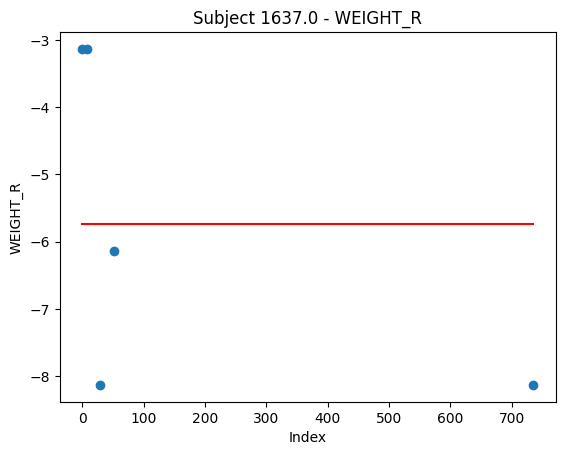

In [7]:
multi_dict = dict(filter(filterer, normalized_dict.items()))

graph_col(normalized_dict, 1637.0, "WEIGHT_R")


In [8]:
print(multi_dict.keys())

dict_keys([25.0, 27.0, 28.0, 39.0, 41.0, 53.0, 54.0, 59.0, 65.0, 67.0, 71.0, 72.0, 78.0, 85.0, 86.0, 91.0, 95.0, 96.0, 100.0, 110.0, 112.0, 116.0, 117.0, 119.0, 120.0, 122.0, 129.0, 132.0, 133.0, 140.0, 143.0, 148.0, 169.0, 171.0, 172.0, 182.0, 184.0, 207.0, 211.0, 212.0, 213.0, 225.0, 226.0, 227.0, 234.0, 236.0, 246.0, 247.0, 251.0, 269.0, 278.0, 282.0, 283.0, 289.0, 299.0, 301.0, 302.0, 308.0, 316.0, 317.0, 323.0, 326.0, 334.0, 347.0, 358.0, 361.0, 376.0, 385.0, 388.0, 389.0, 391.0, 392.0, 394.0, 403.0, 404.0, 407.0, 417.0, 418.0, 426.0, 427.0, 431.0, 439.0, 455.0, 469.0, 470.0, 472.0, 476.0, 484.0, 502.0, 509.0, 517.0, 546.0, 549.0, 550.0, 551.0, 578.0, 583.0, 587.0, 600.0, 604.0, 607.0, 610.0, 621.0, 629.0, 633.0, 639.0, 640.0, 641.0, 662.0, 678.0, 682.0, 695.0, 696.0, 716.0, 729.0, 733.0, 741.0, 750.0, 751.0, 765.0, 767.0, 770.0, 777.0, 784.0, 798.0, 799.0, 800.0, 801.0, 803.0, 804.0, 806.0, 812.0, 819.0, 822.0, 823.0, 825.0, 828.0, 836.0, 844.0, 845.0, 853.0, 859.0, 860.0, 862.0,

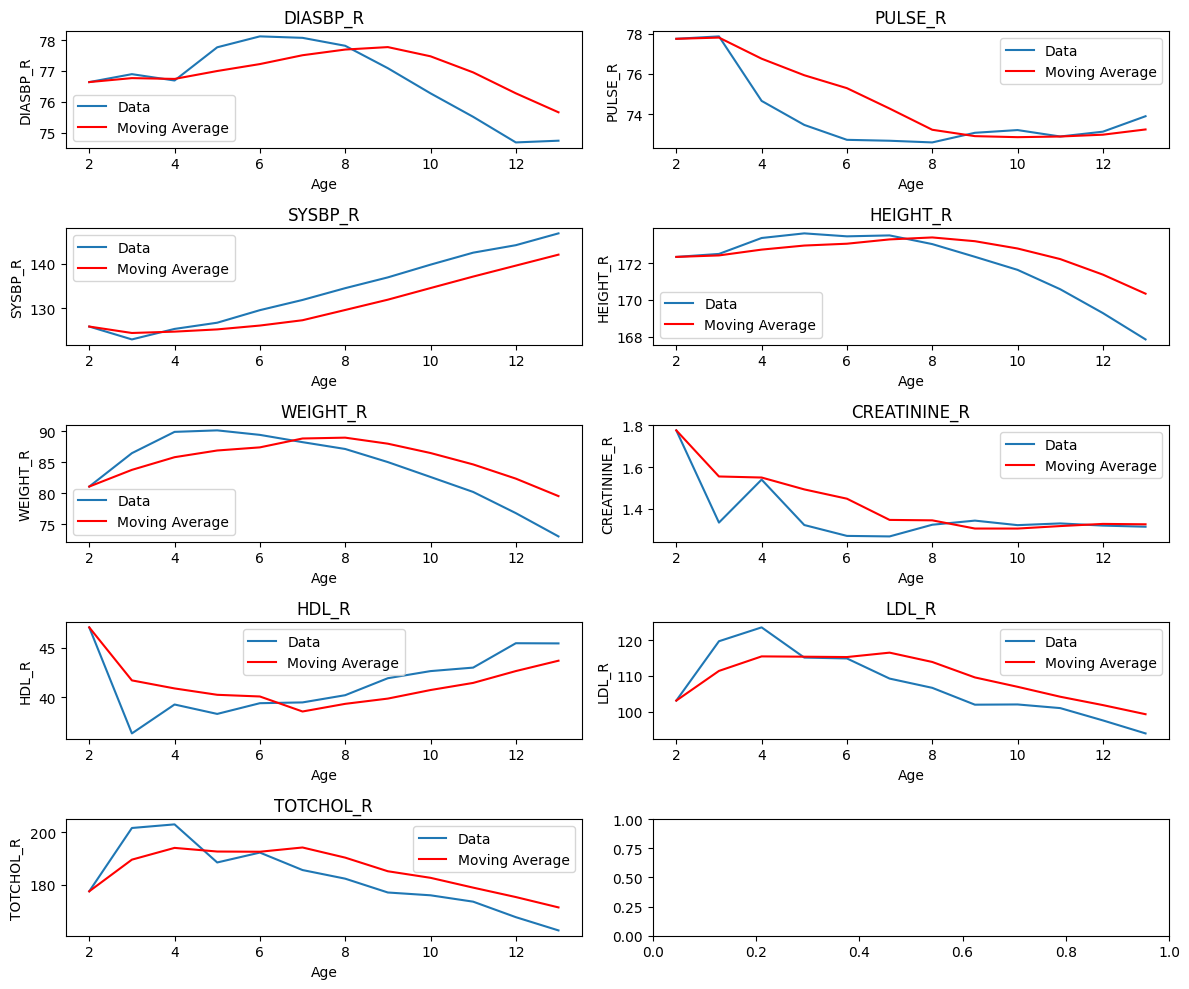

In [9]:
# Get the list of columns in trends
columns = list(trends.keys())

# Determine the number of subplots
num_plots = len(columns)

# Calculate the number of rows and columns for subplots
num_rows = int(math.ceil(num_plots / 2))
num_cols = 2

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 10))

# Flatten the axs array if necessary
if num_plots == 1:
    axs = [axs]

# Iterate over the columns and create subplots
for i, column in enumerate(columns):
    # Calculate the subplot index
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Get the age values and data values for the column
    age_values = list(trends[column].keys())
    data_values = [k for i, k in trends[column].items()]

    # Plot the data on the corresponding subplot
    axs[row_idx][col_idx].plot(age_values, data_values, label="Data")
    
    # Calculate moving average
    window = 5
    moving_avg = []
    for j in range(len(data_values)):
        if j < window:
            window_data = data_values[:j+1]
        else:
            window_data = data_values[j-window+1:j+1]
        avg = sum(window_data) / len(window_data)
        moving_avg.append(avg)
    
    axs[row_idx][col_idx].plot(age_values, moving_avg, color='red', label="Moving Average")
    
    axs[row_idx][col_idx].set_title(column)
    axs[row_idx][col_idx].set_xlabel("Age")
    axs[row_idx][col_idx].set_ylabel(column)
    axs[row_idx][col_idx].legend()

# Adjust the spacing between subplots
fig.tight_layout()

# Show the subplots

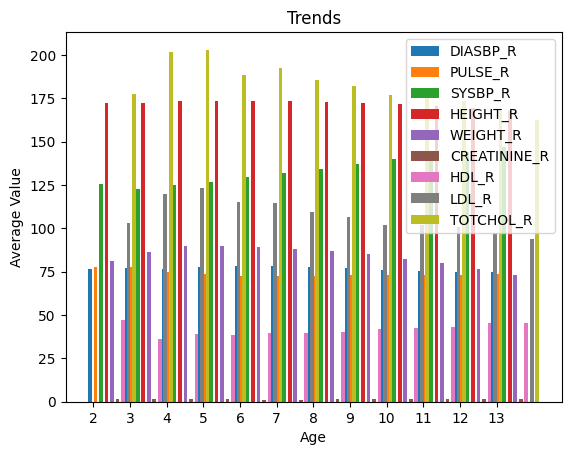

In [10]:
# Get the keys and values from the trends dictionary
trend_keys = list(trends.keys())
age_groups = list(trends[trend_keys[0]].keys())
data = np.array([[trends[col][age] for age in age_groups] for col in trend_keys])


fig, ax = plt.subplots()
width = 0.1
spacing = 0.05
num_cols = len(trend_keys)
x = np.arange(len(age_groups))

for i in range(num_cols):
    offset = (num_cols / 2 - 0.5) * (width + spacing)
    ax.bar(x + (i - offset) * (width + spacing), data[i], width, label=trend_keys[i])

ax.set_xlabel('Age')
ax.set_ylabel('Average Value')
ax.set_title('Trends')
ax.set_xticks(x)
ax.set_xticklabels(age_groups)
ax.legend()
plt.show()

In [33]:
def plot_trends_for_subject(subject_id, trends):
    # Check if the subject ID is present in the trends data
    if any(subject_id in inner_dict.values() for inner_dict in trends.values()):
        # Get the keys and values from the trends dictionary
        trend_keys = list(trends.keys())
        age_groups = list(trends[trend_keys[0]].keys())
        data = np.array([[trends[col][age] for age in age_groups] for col in trend_keys])

        # Find the index corresponding to the subject ID
        subject_index = None
        for index, inner_dict in enumerate(trends.values()):
            if subject_id in inner_dict.values():
                subject_index = index
                break

        # Get the trends for the specified subject
        subject_trends = data[:, subject_index]

        # Plot the bar chart
        fig, ax = plt.subplots()
        x = np.arange(len(trend_keys))

        ax.bar(x, subject_trends)
        ax.set_xlabel('Variables')
        ax.set_ylabel('Average Value')
        ax.set_title(f'Trends for Subject {subject_id}')
        ax.set_xticks(x)
        ax.set_xticklabels(trend_keys, rotation=45)
        plt.show()
    else:
        print(f"Subject ID {subject_id} not found in the trends data.")

# Specify the subject ID for which you want to plot the trends
subject_id = 25.0

# Call the function to plot the trends for the specified subject
plot_trends_for_subject(subject_id, trends)

Subject ID 25.0 not found in the trends data.


In [20]:
print(list(subj_dict.keys()))

[0.0, 2.0, 17.0, 25.0, 26.0, 27.0, 28.0, 39.0, 41.0, 42.0, 44.0, 46.0, 47.0, 49.0, 53.0, 54.0, 59.0, 64.0, 65.0, 66.0, 67.0, 68.0, 70.0, 71.0, 72.0, 78.0, 81.0, 85.0, 86.0, 91.0, 92.0, 95.0, 96.0, 100.0, 103.0, 105.0, 106.0, 110.0, 112.0, 116.0, 117.0, 119.0, 120.0, 122.0, 123.0, 128.0, 129.0, 130.0, 132.0, 133.0, 137.0, 139.0, 140.0, 141.0, 142.0, 143.0, 148.0, 158.0, 167.0, 169.0, 171.0, 172.0, 181.0, 182.0, 183.0, 184.0, 194.0, 198.0, 202.0, 206.0, 207.0, 211.0, 212.0, 213.0, 224.0, 225.0, 226.0, 227.0, 233.0, 234.0, 236.0, 239.0, 246.0, 247.0, 251.0, 269.0, 271.0, 273.0, 275.0, 276.0, 278.0, 279.0, 282.0, 283.0, 286.0, 289.0, 291.0, 299.0, 301.0, 302.0, 305.0, 306.0, 308.0, 310.0, 314.0, 315.0, 316.0, 317.0, 318.0, 319.0, 321.0, 323.0, 324.0, 325.0, 326.0, 327.0, 334.0, 345.0, 347.0, 348.0, 349.0, 358.0, 359.0, 361.0, 365.0, 366.0, 367.0, 368.0, 370.0, 372.0, 375.0, 376.0, 377.0, 380.0, 381.0, 383.0, 384.0, 385.0, 386.0, 388.0, 389.0, 390.0, 391.0, 392.0, 394.0, 398.0, 399.0, 400.0

In [33]:
def polyfit_subj(subj, col):
    irr_time_series = dict()
    for column in col:
        irr_time_series[column] = list()
    for entry in subj:
        for column in col:
            if not math.isnan(entry[column]):
                irr_time_series[column].append((entry["RDAYSFROMINDEX"], entry[column]))
    reg_timeseries = dict()
    for k in irr_time_series.keys():
        irr_time_series[k] = np.array(irr_time_series[k])
        xx = irr_time_series[k][:, 0] - irr_time_series[k][:, 0][0]
        yy = irr_time_series[k][:, 1]
        polynomial = np.polyfit(xx, yy, 3)
        reg_timeseries[k] = np.polyval(polynomial, xx)  # Use xx instead of a fixed range
        print(f'Length of regular time series for {k}: {len(reg_timeseries[k])}')
    return reg_timeseries

def graph_col_with_fit(subj_dict, subj_ids, col):
    num_plots = len(subj_ids)
    fig, axs = plt.subplots(num_plots, sharex=True, figsize=(8, 6))

    for i, subj_id in enumerate(subj_ids):
        if subj_id not in subj_dict:
            print(f"Patient ID {subj_id} not found in the subject dictionary.")
            continue

        ax = axs[i] if num_plots > 1 else axs
        subj_data = subj_dict[subj_id]
        subj_values = [row[col] for row in subj_data]
        subj_days = [row["RDAYSFROMINDEX"] for row in subj_data]
        subj_polyfit = polyfit_subj(subj_data, [col])[col]

        ax.scatter(subj_days[:len(subj_values)], subj_values)
        ax.plot(
            subj_days[:len(subj_polyfit)],
            subj_polyfit
        )

        # Adjust y-axis limits for each subplot
        min_value = min(subj_values + subj_polyfit)
        max_value = max(subj_values + subj_polyfit)
        ax.set_ylim(min_value - 10, max_value + 10)

    plt.xlabel("RDAYSFROMINDEX")
    plt.ylabel(col)
    plt.title(f"Patient Data and Trend for {col}")
    plt.tight_layout()
    plt.show()


In [23]:


subj_dict = create_subj_dict(df)
new_dict = drop_bad_rows(subj_dict, 5)
print(len(new_dict))

# print(f'Missing Value Entry: {subj_dict[2][0]["HDL_R"]}')
# # print(find_threshold_num_visits(subj_dict, 0.01))
# # print(find_threshold_num_visits(subj_dict, 100, percentage=False))
# print(avg_interval(subj_dict))
# print(avg_interval(subj_dict, per_instance=False))
# def custom_filter_func(pair):
#     key, value = pair
#     if len(value) >= 9 and ((value[-1]["RDAYSFROMINDEX"] - value[0]["RDAYSFROMINDEX"]) > 750):
#         return True
#     else:
#         return False
# # print(avg_interval(subj_dict, custom_filterer=custom_filter_func))

# def filterer(pair):
#     key, value = pair
#     if len(value) >= 17:
#         return True
#     return False

# # full_dict = remove_missing(subj_dict, "HDL_R")

# # multi_dict = dict(filter(filterer, full_dict.items()))
# # print(list(multi_dict.keys()))

# # graph_col(subj_dict, 91208.0, "YRCATH_G")

# split_subj = split_dict(subj_dict, 1000)
# split_subj = flatten_split_dict(split_subj)

# full_dict = remove_missing(split_subj, "TOTCHOL_R")
 
# multi_dict = dict(filter(custom_filter_func, full_dict.items()))
# print(f'Length of final dataset: {len(list(multi_dict.keys()))}')
# print(list(multi_dict.keys()))

# graph_col(split_subj, 90195.1, "HDL_R")
# graph_col_with_fit(split_subj, 82315.1, "HDL_R")

# # plt.plot(list(range(int(split_subj[41343.2][0]["RDAYSFROMINDEX"]), int(split_subj[41343.2][0]["RDAYSFROMINDEX"]) + 1100, 100)), polyfit_subj(split_subj[41343.2], ["DIASBP_R"])["DIASBP_R"])

# print(find_threshold_num_visits(dict(filter(custom_filter_func, split_subj.items())), 0.01))
# print(find_threshold_num_visits(dict(filter(custom_filter_func, split_subj.items())), 100, percentage=False))
# print(avg_interval(dict(filter(custom_filter_func, split_subj.items())), min_instances=9))
# print(avg_interval(dict(filter(custom_filter_func, split_subj.items())), min_instances=9, per_instance=False))

# print(find_threshold_num_visits(multi_dict, 0.01))
# print(find_threshold_num_visits(multi_dict, 100, percentage=False))
# print(avg_interval(multi_dict, min_instances=9))
# print(avg_interval(multi_dict, min_instances=9, per_instance=False))

1874


In [24]:
subjects = dict()
for index, row in df.iterrows():
    if row["RSUBJID"] not in subjects.keys():
        subjects[row["RSUBJID"]] = list()

    subjects[row["RSUBJID"]].append(row.drop(columns="RSUBJID"))

num_vist_count = dict()
for k in subjects.keys():
    instances = len(subjects[k])
    if instances not in num_vist_count.keys():
        num_vist_count[instances] = 0

    num_vist_count[instances] += 1

for length, num in num_vist_count.items():
    print(f' {length}: {num}')

 1: 22076
 24: 6
 14: 42
 5: 1232
 4: 1970
 2: 7771
 3: 3713
 8: 315
 9: 221
 6: 740
 13: 47
 31: 3
 11: 106
 19: 13
 17: 25
 10: 141
 7: 463
 16: 31
 12: 77
 23: 5
 18: 20
 20: 7
 15: 31
 25: 1
 26: 3
 27: 3
 22: 12
 32: 1
 29: 2
 28: 4
 21: 8
 36: 2
 40: 3
 30: 2
 46: 1
 33: 1


In [24]:
from imblearn.over_sampling import SMOTE

# Remove rows with NaN values
df.dropna(inplace=True)

filtered_dict = {k: v for k, v in subj_dict.items() if len(v) > 1}

features = []
target = []
for k, v in filtered_dict.items():
    for row in v:
        if row.drop(columns=["RSUBJID", "PostCond"]).notna().all():
            features.append(row.drop(columns=["RSUBJID", "PostCond"]))
            target.append(row["PostCond"])

smote = SMOTE(sampling_strategy='minority')
upscaled_features, upscaled_target = smote.fit_resample(features, target)

upscaled_df = pd.DataFrame(upscaled_features, columns=features[0].index)
upscaled_df["PostCond"] = upscaled_target

print(upscaled_df['PostCond'].value_counts())


1.0    14991
0.0    14991
Name: PostCond, dtype: int64


In [25]:
# Determine the number of visits with the number of patients
subjects = {}
for index, row in upscaled_df.iterrows():
    if row["RSUBJID"] not in subjects:
        subjects[row["RSUBJID"]] = []

    subjects[row["RSUBJID"]].append(row.drop(columns="RSUBJID"))

num_vist_count = {}
for k in subjects.keys():
    instances = len(subjects[k])
    if instances not in num_vist_count:
        num_vist_count[instances] = 0

    num_vist_count[instances] += 1

num_vist_count = dict(sorted(num_vist_count.items()))
count_patients = 0
for length, num in num_vist_count.items():
    print(f"{length}: {num}")
    if length != 1:
        count_patients += num
print("Total number of patients: " + str(count_patients))


1: 10296
2: 2928
3: 1231
4: 653
5: 363
6: 181
7: 126
8: 76
9: 62
10: 53
11: 26
12: 28
13: 10
14: 16
15: 7
16: 12
17: 6
18: 5
19: 5
20: 3
21: 1
22: 3
23: 4
24: 1
25: 2
26: 1
27: 2
29: 1
30: 1
34: 1
Total number of patients: 5808


The length of PostCond_True: 4848
The length of PostCond_False: 960


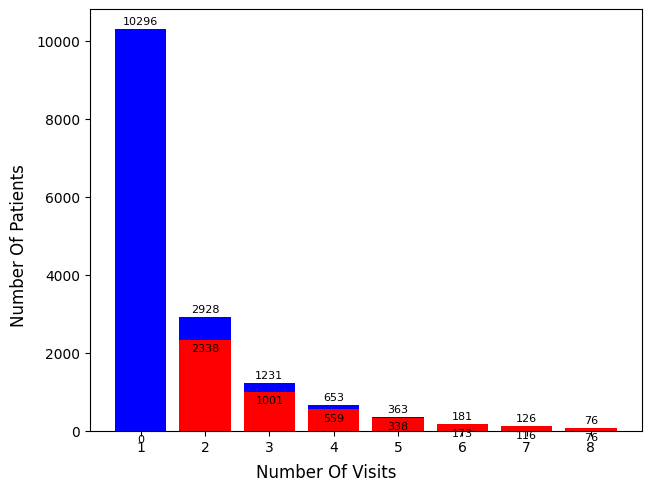

In [26]:
visits_per_patient = {}
for k in subjects.keys():
    instances = len(subjects[k])
    if instances not in visits_per_patient:
        visits_per_patient[instances] = []

    visits_per_patient[instances].append(k)

visits_per_patient = dict(sorted(visits_per_patient.items()))

# Determine the number of true postcond
postcond_true = []
for k in subjects.keys():
    visits = subjects[k]
    if k not in visits_per_patient[1]:  # Excluding all patients that visit once
        for instance in visits:
            if instance["PostCond"] == 1.0:
                if k not in postcond_true:
                    postcond_true.append(k)  # If any of their visits have a postcond value of 1.0

# Determine the number of false postcond (and which ids)
postcond_false = []
for k in subjects.keys():
    if k not in visits_per_patient[1]:  # Excluding all patients that visit once
        if k not in postcond_true:
            postcond_false.append(k)

#print("Total number of patients: " + str(len(df_resampled)))
print("The length of PostCond_True: " + str(len(postcond_true)))
print("The length of PostCond_False: " + str(len(postcond_false)))

#del visits_per_patient[1]  # Remove all patients who only visit once

min_val, max_val = 1, 8
fig = plt.figure(layout="constrained")
ax_dict = fig.subplots(1, 1)
for k in visits_per_patient.keys():
    if min_val <= k <= max_val:
        # Plot patients who had true postcond
        count = 0
        for patient in visits_per_patient[k]:
            if patient in postcond_true:
                count += 1
        bar_1 = ax_dict.bar(k, count, color="red")
        ax_dict.bar_label(bar_1, padding=-10, fontsize=8)

        # Plot patients who had false postcond
        bar_0 = ax_dict.bar(k, len(visits_per_patient[k]) - count, bottom=count, color="blue")
        ax_dict.bar_label(bar_0, padding=2, fontsize=8)

fig.supxlabel("Number Of Visits")
fig.supylabel("Number Of Patients")
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Separate rows with PostCond value 0 and 1
df_postcond_0 = df[df['PostCond'] == 0]
df_postcond_1 = df[df['PostCond'] == 1]

# Create X and y arrays for SMOTE
X = df_postcond_0.drop('PostCond', axis=1)  # Features 
y = df_postcond_0['PostCond']  # Target variable

# Remove rows with missing values
X = X.dropna()
y = y[X.index]

# Apply SMOTE to upsample the minority class
smote = SMOTE(sampling_strategy=0.5)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine the upsampled minority class (PostCond 0) with the majority class (PostCond 1)
df_upsampled = pd.concat([pd.DataFrame(X_resampled), pd.Series(y_resampled, name='PostCond')], axis=1)

# Concatenate the upsampled DataFrame with the original PostCond 1 DataFrame
df_balanced = pd.concat([df_upsampled, df_postcond_1], ignore_index=True)